In [1]:
from google.colab import files
files.upload()  # upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tanaynagarkar","key":"16dbf0042ffb796fb13d284bda07be50"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tanaynagarkar/pc3-data -p /content/
!unzip -q /content/pc3-data.zip -d /content/PC3_data


Dataset URL: https://www.kaggle.com/datasets/tanaynagarkar/pc3-data
License(s): CC0-1.0
100% 3.01G/3.02G [00:25<00:00, 225MB/s]
100% 3.02G/3.02G [00:25<00:00, 127MB/s]


In [ ]:
!pip install tensorflow numpy tqdm


In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras import layers, models, backend as K
from glob import glob
from tqdm import tqdm

# --- Paths and parameters ---
image_size = (256, 256)
train_img_dir = "/content/PC3_data/PC3_data_split/train/images"
train_mask_dir = "/content/PC3_data/PC3_data_split/train/masks"
test_img_dir = "/content/PC3_data/PC3_data_split/test/images"
test_mask_dir = "/content/PC3_data/PC3_data_split/test/masks"
batch_size = 8
epochs = 40

# --- Load data ---
def load_data(img_dir, mask_dir):
    img_paths = sorted(glob(os.path.join(img_dir, "*")))
    mask_paths = sorted(glob(os.path.join(mask_dir, "*")))
    X, Y = [], []
    for img_path, mask_path in tqdm(zip(img_paths, mask_paths), total=len(img_paths)):
        img = load_img(img_path, target_size=image_size, color_mode="grayscale")
        mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
        img = img_to_array(img) / 255.0
        mask = img_to_array(mask) / 255.0
        mask = np.where(mask > 0.5, 1, 0)
        X.append(img)
        Y.append(mask)
    return np.array(X), np.array(Y)

X_train, Y_train = load_data(train_img_dir, train_mask_dir)
X_test, Y_test = load_data(test_img_dir, test_mask_dir)

# --- U-Net blocks ---
def conv_block(x, filters):
    c = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    c = layers.Conv2D(filters, 3, activation="relu", padding="same")(c)
    return c

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2, 2))(c)
    return c, p

def decoder_block(x, skip, filters):
    us = layers.UpSampling2D((2, 2))(x)
    concat = layers.Concatenate()([us, skip])
    c = conv_block(concat, filters)
    return c

# --- Build U-Net ---
inputs = layers.Input(shape=(256, 256, 1))
c1, p1 = encoder_block(inputs, 64)
c2, p2 = encoder_block(p1, 128)
c3, p3 = encoder_block(p2, 256)
c4, p4 = encoder_block(p3, 512)
bn = conv_block(p4, 1024)
d1 = decoder_block(bn, c4, 512)
d2 = decoder_block(d1, c3, 256)
d3 = decoder_block(d2, c2, 128)
d4 = decoder_block(d3, c1, 64)
outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(d4)
model = models.Model(inputs, outputs)

# --- Metrics ---
def iou_metric(y_true, y_pred):
    y_true = K.cast(y_true, "float32")
    y_pred = K.cast(y_pred > 0.5, "float32")
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())

def dice_metric(y_true, y_pred):
    y_true = K.cast(y_true, "float32")
    y_pred = K.cast(y_pred > 0.5, "float32")
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())

# --- BCE + Dice loss ---
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1e-6) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1e-6)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return 0.5 * bce + 0.5 * d_loss

# --- Compile & train ---
model.compile(optimizer="adam", loss=bce_dice_loss, metrics=[iou_metric, dice_metric])
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=batch_size, epochs=epochs)
model.save("/content/drive/MyDrive/unet_model.h5")

# --- Predictions ---
preds = model.predict(X_test)
preds = (preds > 0.5).astype(np.float32)

# --- Evaluation ---
def compute_scores(y_true, y_pred):
    y_true_f = y_true.reshape(-1)
    y_pred_f = y_pred.reshape(-1)
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    iou = intersection / (union + 1e-7)
    dice = (2 * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1e-7)
    TP = np.sum(np.logical_and(y_true_f == 1, y_pred_f == 1))
    TN = np.sum(np.logical_and(y_true_f == 0, y_pred_f == 0))
    FP = np.sum(np.logical_and(y_true_f == 0, y_pred_f == 1))
    FN = np.sum(np.logical_and(y_true_f == 1, y_pred_f == 0))
    precision = TP / (TP + FP + 1e-7)
    recall = TP / (TP + FN + 1e-7)
    specificity = TN / (TN + FP + 1e-7)
    return iou, dice, precision, recall, specificity

ious, dices, precisions, recalls, specificities = [], [], [], [], []
for i in range(len(Y_test)):
    iou, dice, precision, recall, specificity = compute_scores(Y_test[i], preds[i])
    ious.append(iou)
    dices.append(dice)
    precisions.append(precision)
    recalls.append(recall)
    specificities.append(specificity)

print("Mean IoU:", np.mean(ious))
print("Mean Dice:", np.mean(dices))
print("Mean Precision:", np.mean(precisions))
print("Mean Recall:", np.mean(recalls))
print("Mean Specificity:", np.mean(specificities))


100%|██████████| 114/114 [00:13<00:00,  8.20it/s]


Epoch 1/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - dice_metric: 0.0648 - iou_metric: 0.0438 - loss: 0.6997 - val_dice_metric: 0.0000e+00 - val_iou_metric: 0.0000e+00 - val_loss: 0.4654
Epoch 2/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 491ms/step - dice_metric: 0.4201 - iou_metric: 0.3249 - loss: 0.4443 - val_dice_metric: 0.8600 - val_iou_metric: 0.7555 - val_loss: 0.1867
Epoch 3/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 488ms/step - dice_metric: 0.8778 - iou_metric: 0.7834 - loss: 0.1588 - val_dice_metric: 0.8894 - val_iou_metric: 0.8013 - val_loss: 0.1465
Epoch 4/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 488ms/step - dice_metric: 0.9145 - iou_metric: 0.8432 - loss: 0.1132 - val_dice_metric: 0.8994 - val_iou_metric: 0.8176 - val_loss: 0.1397
Epoch 5/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 490ms/step - dice_metric: 0.9277 - iou_metric: 0.8658 - loss: 0.0983 - val_dice_metric: 0.9398 - val_iou_metric: 0.8868 - val_loss: 0.0805
Epoch 6/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 491ms/step - dice_metric: 0.9456 - iou_metric: 

4/4 ━━━━━━━━━━━━━━━━━━━━ 79s 10s/step
Mean IoU: 0.9159488155615372
Mean Dice: 0.9554334538022837
Mean Precision: 0.9586523530370475
Mean Recall: 0.9543347453565788
Mean Specificity: 0.9875223522882178


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


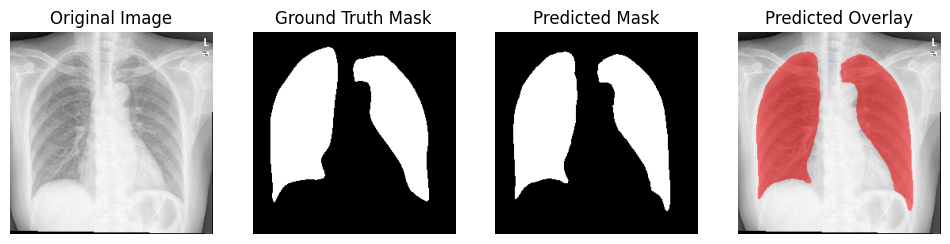

In [14]:
import matplotlib.pyplot as plt
import random

# --- Pick a random test image ---
idx = random.randint(0, len(X_test) - 1)
img = X_test[idx]  # shape (256,256,1)
true_mask = Y_test[idx]  # shape (256,256,1)

# --- Predict mask ---
pred_mask = model.predict(img[np.newaxis, ...])[0]  # shape (256,256,1)
pred_mask_bin = (pred_mask > 0.5).astype(np.float32)

# --- Create semi-transparent overlay ---
overlay = np.stack([img.squeeze()]*3, axis=-1)  # convert grayscale to RGB
red_mask = np.zeros_like(overlay)
red_mask[..., 0] = 1.0  # red channel
alpha = 0.5  # transparency factor

overlay = np.where(pred_mask_bin.squeeze()[..., None] == 1,
                   (1 - alpha)*overlay + alpha*red_mask, overlay)

# --- Plot ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(img.squeeze(), cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(pred_mask_bin.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(overlay)
plt.title("Predicted Overlay")
plt.axis('off')

plt.show()
